In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from pathlib import Path

In [15]:
#export
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

In [18]:
#export
from exp.nb_callbacks import *
from exp.nb_utils import listify
from exp.nb_metrics import Metric, AvgMetric
from exp.nb_schedules import combined_cos

In [8]:
#export
def make_metric(m):
    return m if isinstance(m, Metric) else AvgMetric(m)

In [65]:
#export
class Learner:
    _default_cbs = [TrainEvalCallback]

    ALL_CBS = {
    'begin_fit', 'begin_epoch', 'begin_train', 'begin_batch',
    'after_pred', 'after_loss', 'after_backward', 'after_step',
    'after_batch', 'after_train', 'begin_validate', 'after_validate',
    'after_epoch', 'after_fit', 'after_cancel_fit',
    'after_cancel_batch', 'after_cancel_epoch', 'after_cancel_train', 'after_cancel_validate'}

    def __init__(self, model, data, loss_func,
                 opt_func, lr=1e-2, wd=None, moms=(0.95, 0.85, 0.95),
                 metrics=None, cbs=None, cb_funcs=None,
                 path=Path('.'), model_dir='models'):
        self.model, self.data, self.loss_func = model, data, loss_func
        self.opt_func, self.lr, self.metrics = opt_func, lr, metrics
        self.wd, self.moms = wd, moms
        self.path = path
        self.model_dir = self.path / model_dir

        self.opt = None
        self.cbs = []
        self.in_train = False
        self.epoch = 0
        self.epochs = 1
        self.loss = tensor(0.)
        self.logger = print

        self.add_cbs([cb() for cb in self._default_cbs])
        self.add_cbs(cbs)
        self.add_cbs([cbf() for cbf in listify(cb_funcs)])

    @property
    def metrics(self): return self._metrics

    @metrics.setter
    def metrics(self, metrics):
        self._metrics = list(map(make_metric, metrics))

    def set_logger(self, logger):
        self.logger = logger

    def add_cb(self, cb):
        cb.set_learner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)

    def get_params(self):
        return self.model.parameters()

    def _do_begin_fit(self, epochs):
        self.epochs = epochs
        self.loss = tensor(0.)
        self('begin_fit')

    def _do_epoch_train(self):
        try:
            self.dl = self.data.train_dl;                           self('begin_train')
            self.all_batches()
        except CancelTrainException:                                self('after_cancel_train')
        finally:                                                    self('after_train')

    def _do_epoch_validate(self):
        try:
            self.dl = self.data.valid_dl;                           self('begin_validate')
            with torch.no_grad():
                self.all_batches()
        except CancelValidException:                                self('after_cancel_validate')
        finally:                                                    self('after_validate')

    def one_batch(self, i, xb, yb):
        self.iter = i
        try:
            self.xb, self.yb = xb, yb;                              self('begin_batch')
            self.pred = self.model(self.xb);                        self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb);         self('after_loss')
            # If validate
            if not self.in_train: return
            self.loss.backward();                                   self('after_backward')
            self.opt.step();                                        self('after_step')
            self.opt.zero_grad();
        except CancelBatchException:                                self('after_cancel_batch')
        finally:                                                    self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        for i, (xb, yb) in enumerate(self.dl):
            self.one_batch(i, xb, yb);

    def _end_cleanup(self):
        self.dl, self.xb, self.yb, self.pred, self.loss = None, (None,), (None,), None, None

    def fit(self, epochs, lr=None, wd=None, cbs=None, reset_opt=False):
        self.add_cbs(cbs)

        if lr is None:
            lr = self.lr
        if wd is None:
            wd = self.wd
        if reset_opt or not self.opt:
            self.opt = self.opt_func(self.get_params(), lr=lr)

        for p in self.opt.param_groups:
            p['lr'] = lr
            if wd is not None:
                p['weight_decay'] = wd

        try:
            self._do_begin_fit(epochs)
            for epoch in range(epochs):
                try:
                    self.epoch = epoch;                             self('begin_epoch')
                    self._do_epoch_train()
                    self._do_epoch_validate()
                except CancelEpochException:                        self('after_cancel_epoch')
                finally:                                            self('after_epoch')
        except CancelFitException:                                  self('after_cancel_fit')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)
            self._end_cleanup()

    def fit_one_cycle(self, epochs, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                      moms=None, cbs=None, reset_opt=False):
        lr = lr_max
        if lr is None:
            lr = self.lr
        if reset_opt or not self.opt:
            self.opt = self.opt_func(self.get_params(), lr=lr)
        for p in self.opt.param_groups:
            p['lr'] = lr
        lr_max = np.array([p['lr'] for p in self.opt.param_groups])
        scheds = {
            'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
            'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))
        }
        self.fit(epochs, cbs=[ParamScheduler(scheds)] + listify(cbs), reset_opt=reset_opt, wd=wd)


    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cb_name) and res
        return res

    def save(self, file, with_opt=True, prickle_proptocol=2):
        self.model_dir.mkdir(parents=True, exist_ok=True)
        file = self.model_dir / (file+'.pth')
        if self.opt is None:
            with_opt = False
        state = self.model.state_dict()
        if with_opt:
            state = {
                'model': state,
                'opt': self.opt.state_dict()
            }
        torch.save(state, file, pickle_protocol=prickle_proptocol)

    def load(self, file, with_opt=False, strict=True):
        if self.opt is None:
            self.opt = self.opt_func(self.get_params(), lr=self.lr)
        file = self.model_dir / (file+'.pth')
        state = torch.load(file)
        hasopt = set(state) == {'model', 'opt'}
        model_state = state['model'] if hasopt else state
        self.model.load_state_dict(model_state, strict=strict)
        if hasopt and with_opt:
            try:
                self.opt.load_state_dict(state['opt'])
            except:
                if with_opt:
                    print('[ERROR] Could not load optimizer state.')
        elif with_opt:
            print('[WARN] Saved file doenst contain an optimizer state.')
        return self

In [51]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds[0][0].shape[0]
    print(data.train_ds[0][0].shape)
    model = nn.Sequential(nn.Conv2d(m,nh, 7, 2), nn.ReLU(),
                          nn.Conv2d(nh,nh*2, 5, 2), nn.ReLU(),
                          nn.Conv2d(nh*2,nh*2*2, 3, 2), nn.ReLU(),
                          nn.Conv2d(nh*4,nh*8, 3, 2), nn.ReLU(),
                          nn.AdaptiveAvgPool2d(1),
                          nn.Flatten(), nn.Linear(400,data.c))
    return model

In [52]:
from exp.nb_dataset import get_skin_databunch
db = get_skin_databunch(size=64*2)

In [53]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [54]:
from functools import partial

In [55]:
mdl = get_model(db)

torch.Size([3, 450, 600])


In [56]:
import torchvision.models as models
from torchvision import transforms as T

resnet18 = models.resnet18(pretrained=True)
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])

In [35]:
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 7)

In [38]:
# device = torch.device('cuda',0); device
# torch.cuda.set_device(device)
# db = get_skin_databunch(size=None)

In [46]:

learner = Learner(resnet18, db, F.cross_entropy, optim.Adam, metrics=[accuracy], cb_funcs=[Recorder, ProgressCallback])
learner.opt = learner.opt_func(learner.get_params())
for p in learner.opt.param_groups:
    print(p['lr'])

0.001


In [73]:
learner = Learner(resnet18, db, F.cross_entropy, optim.Adam, metrics=[accuracy], cb_funcs=[Recorder, ProgressCallback])
learner.fit_one_cycle(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,7.722634,0.031250,1268.751465,0.000000,01:16


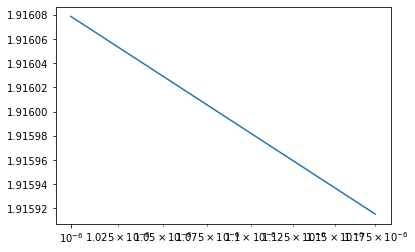

In [18]:
learner.recorder.plot()

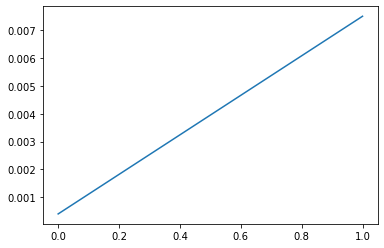

In [74]:
plt.plot(learner.recorder.lrs)

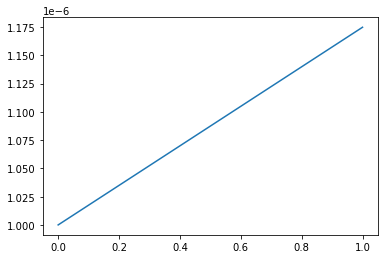

In [20]:
learner.recorder.plot_lr()

In [88]:
!python notebook2script.py learner.ipynb

Converted learner.ipynb to exp\nb_learner.py


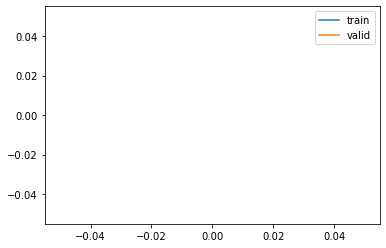

In [80]:
learner.recorder.plot_loss()

In [76]:
learner.recorder.values

[[0.08335184305906296, 0.9921875, 15322657.0, 0.6640625],
 [0.08351955562829971, 0.9921875, 2747838.5, 0.6640625]]

In [93]:
idx = (np.array(learner.recorder.iters)<5).sum()
idx

2

In [79]:
learner.recorder.values

[[0.08335184305906296, 0.9921875, 15322657.0, 0.6640625],
 [0.08351955562829971, 0.9921875, 2747838.5, 0.6640625]]